In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

In [115]:
#getting data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifex_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

## Intro

What factors influence a national life expectancy?  This dataset includes annual data on immunization, mortality, economics, and social factors, and aims to increase the understanding of how such factors affect life expectancy.  In this report, we will explore and clean the data, and then engineer a feature set that could be used for modeling to answer this important question.  The data is made avalable by the WHO and can be found here: https://www.kaggle.com/kumarajarshi/life-expectancy-who.

## Data Exploration and Cleaning

In [116]:
lifex_df2 = lifex_df

In [117]:
## format the column names
lifex_df2.columns = lifex_df2.columns.str.strip()
lifex_df2.columns = lifex_df2.columns.str.lower()
lifex_df2.columns = lifex_df2.columns.str.replace(' ', '_')

In [118]:
#taking our first look at the data
lifex_df2.head(10)

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [119]:
#having a look at some summary stats
lifex_df2.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [120]:
#checking the data types of the columns
lifex_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-null

The above info list suggests that we have some missing values in the data.  Let's explore them.

In [121]:
# check percentage of null values

missing_values_ratios = (lifex_df2.isnull().sum()/lifex_df2.isnull().count())
missing_values_ratios.sort_values(ascending=False)

population                         0.221920
hepatitis_b                        0.188223
gdp                                0.152485
total_expenditure                  0.076923
alcohol                            0.066031
income_composition_of_resources    0.056841
schooling                          0.055480
bmi                                0.011572
thinness__1-19_years               0.011572
thinness_5-9_years                 0.011572
diphtheria                         0.006467
polio                              0.006467
adult_mortality                    0.003404
life_expectancy                    0.003404
under-five_deaths                  0.000000
hiv/aids                           0.000000
measles                            0.000000
percentage_expenditure             0.000000
infant_deaths                      0.000000
status                             0.000000
year                               0.000000
country                            0.000000
dtype: float64

- The top seven variables in the above list are missing a quite a bit of data, from about 5% on the low end to 22% on the top. We will need a strategy to fill these in.
 
- The next five variables (from bmi to polio) are less worrisome, because they are missing only around 1% of the data.

- The last two variables that show missing data are adult_mortality and life expectancy.  We will drop these missing values, as they are a very small percentage of the data, and especially because one of them is our target variable. They also have conspicuously equivalent missing value ratios, so those are probably from the same entries.

In [122]:
#dropping some values

lifex_df2.dropna(subset=['life_expectancy'], inplace=True)

In [123]:
missing_values_ratios = (lifex_df2.isnull().sum()/lifex_df2.isnull().count())
missing_values_ratios.sort_values(ascending=False).head(13)

population                         0.219945
hepatitis_b                        0.188866
gdp                                0.151298
total_expenditure                  0.077186
alcohol                            0.065915
schooling                          0.054645
income_composition_of_resources    0.054645
bmi                                0.010929
thinness__1-19_years               0.010929
thinness_5-9_years                 0.010929
diphtheria                         0.006489
polio                              0.006489
under-five_deaths                  0.000000
dtype: float64

- Sure enough, dropping the missing values from 'life_expectancy' also removed our missing values from 'adult_mortality'
- Now we can look into the other variables with missing data more closely 

In [124]:
lifex_df2['population'].value_counts(dropna=False).head(3)

NaN         644
444.0         4
127445.0      2
Name: population, dtype: int64

In [125]:
#check the indices of missing data
np.where(pd.isnull(lifex_df2['population']))

(array([  37,   65,   66,   67,   68,   69,   70,   71,   72,   73,   74,
          75,   76,   77,   78,   79,   80,  161,  162,  163,  164,  165,
         166,  167,  168,  169,  170,  171,  172,  173,  174,  175,  176,
         177,  178,  179,  180,  181,  182,  183,  184,  185,  186,  187,
         188,  189,  190,  191,  192,  209,  210,  211,  212,  213,  214,
         215,  216,  217,  218,  219,  220,  221,  222,  223,  224,  305,
         306,  307,  308,  309,  310,  311,  312,  313,  314,  315,  316,
         317,  318,  319,  320,  369,  370,  371,  372,  373,  374,  375,
         376,  377,  378,  379,  380,  381,  382,  383,  384,  433,  434,
         435,  436,  437,  438,  439,  440,  441,  442,  443,  444,  445,
         446,  447,  608,  609,  610,  611,  612,  613,  614,  615,  616,
         617,  618,  619,  620,  621,  622,  623,  656,  657,  658,  659,
         660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,
         671,  688,  689,  690,  691, 

- The array of indices above indicates that 'population' data is missing from many entries spread throughout the entire dataset.  
- Looking closely at this list of indices reveals that they are mostly consecutive groups. We suspect that the 'country' column is arranged alphabetically, which would suggest that each grouping of consecutive integers represents a specific country missing population data. Let's check!

In [126]:
lifex_df2['country'][64:82]

64                 Angola
65    Antigua and Barbuda
66    Antigua and Barbuda
67    Antigua and Barbuda
68    Antigua and Barbuda
69    Antigua and Barbuda
70    Antigua and Barbuda
71    Antigua and Barbuda
72    Antigua and Barbuda
73    Antigua and Barbuda
74    Antigua and Barbuda
75    Antigua and Barbuda
76    Antigua and Barbuda
77    Antigua and Barbuda
78    Antigua and Barbuda
79    Antigua and Barbuda
80    Antigua and Barbuda
81              Argentina
Name: country, dtype: object

In [127]:
lifex_df2['country'][160:194]

160    Azerbaijan
161       Bahamas
162       Bahamas
163       Bahamas
164       Bahamas
165       Bahamas
166       Bahamas
167       Bahamas
168       Bahamas
169       Bahamas
170       Bahamas
171       Bahamas
172       Bahamas
173       Bahamas
174       Bahamas
175       Bahamas
176       Bahamas
177       Bahrain
178       Bahrain
179       Bahrain
180       Bahrain
181       Bahrain
182       Bahrain
183       Bahrain
184       Bahrain
185       Bahrain
186       Bahrain
187       Bahrain
188       Bahrain
189       Bahrain
190       Bahrain
191       Bahrain
192       Bahrain
193    Bangladesh
Name: country, dtype: object

- We were correct! The data missing in chunks is associated with specific countries.  This is probably a case of MAR (Mising At Random) data, perhaps because certain developing countries lack the resources or infrastructure to report on some of these variables.
- There is too much data missing to drop, so we should fill it in to continue with feature engineering.  We know that the data is not necessarily well-ordered, so interpolation is not a good strategy either.  The best strategy for this data is probably imputation with the median, since we also know from our statistical summary above and boxplots below that there are many extreme outliers in this data (making the mode a poor choice for imputation).

In [128]:
#filling in missing values via imputation of the median
columns = ['population','hepatitis_b','gdp','total_expenditure','alcohol','schooling',
           'income_composition_of_resources','bmi','thinness__1-19_years','thinness_5-9_years', 'diphtheria',
          'polio']

#interpolate missing values
for column in columns:
    lifex_df2[column].fillna(lifex_df2[column].median(), inplace=True)
    

In [129]:
missing_values_ratios = (lifex_df2.isnull().sum()/lifex_df2.isnull().count())
missing_values_ratios.sort_values(ascending=False).head(5)

schooling                          0.0
income_composition_of_resources    0.0
year                               0.0
status                             0.0
life_expectancy                    0.0
dtype: float64

Now our data is free of missing values.

## Data Exploration and Cleaning: Visual

We have already seen from the summary stats above that there are some outliers in this data, but lets get a better idea of what's going on with some boxplot visualizations.

In [130]:
lifex_df2_numeric = lifex_df2.drop(['country', 'status'], axis=1)

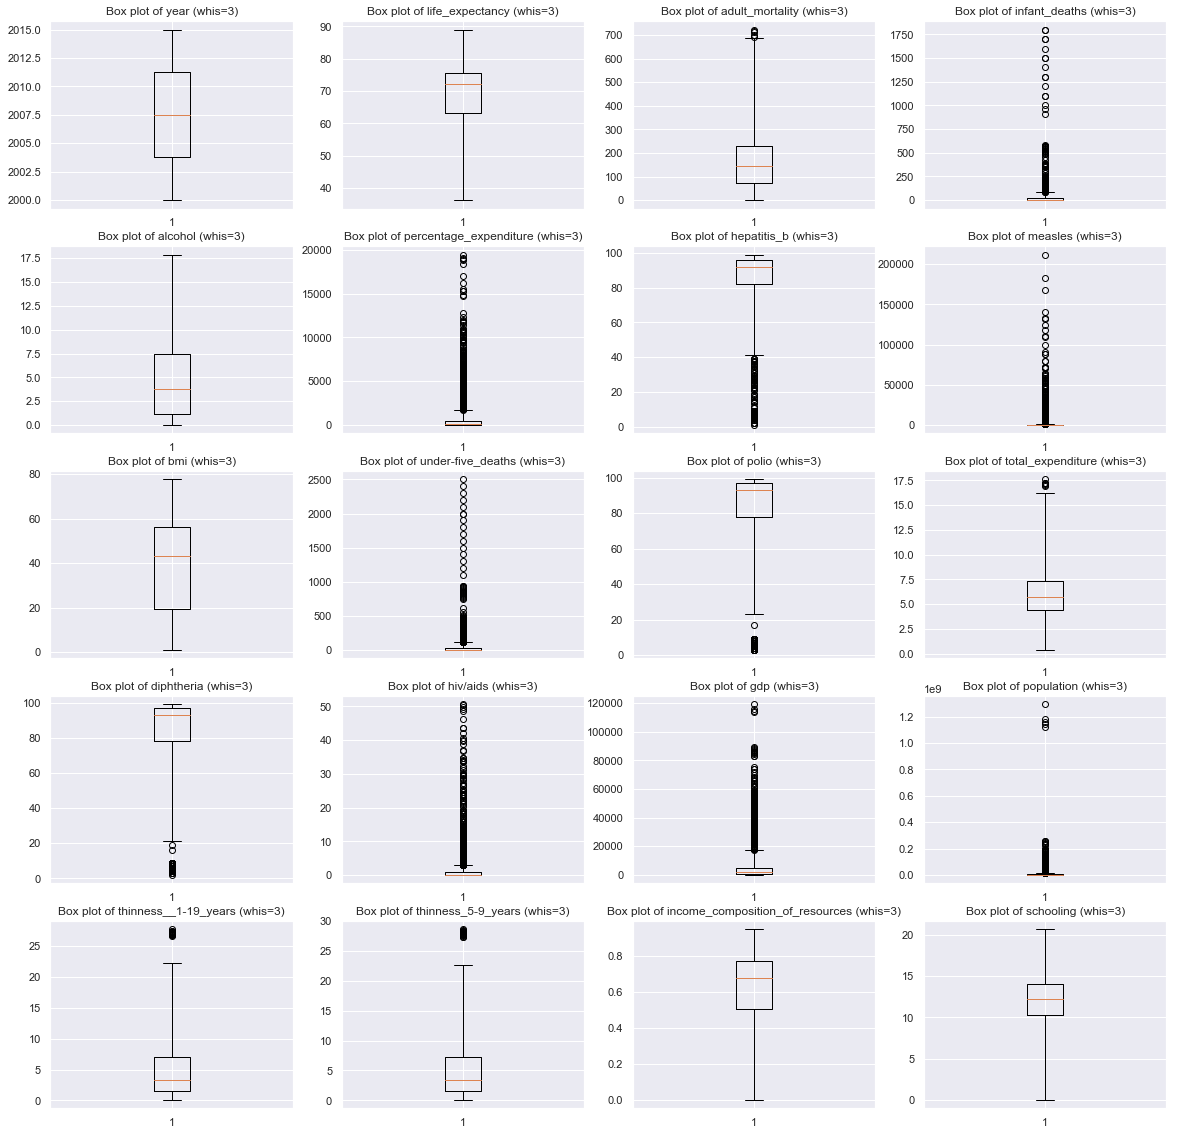

In [131]:
## check for outliers in boxplots

plt.figure(figsize = (20,20))

i = 1

for col in lifex_df2_numeric.columns:
    plt.subplot(5,4,i)
    plt.boxplot(lifex_df2[col], whis=3)
    plt.title("Box plot of {} (whis=3)".format(col))
    i+=1
    
plt.show()

- With a 'whis' threshold of 3, several variables show a lot of extreme outliers: infant_deaths, measles, under-five_deaths, hiv/aids, percentage_expenditure, gdp and population really stand out. A few other variables show fewer and less extreme outliers.
- We can make our data more model-friendly by removing outliers through winsorization, but some of these variables are so extreme in terms of outliers that we should consider some log-transformations first.
- Let's explore the idea of log-transformations with some histograms.

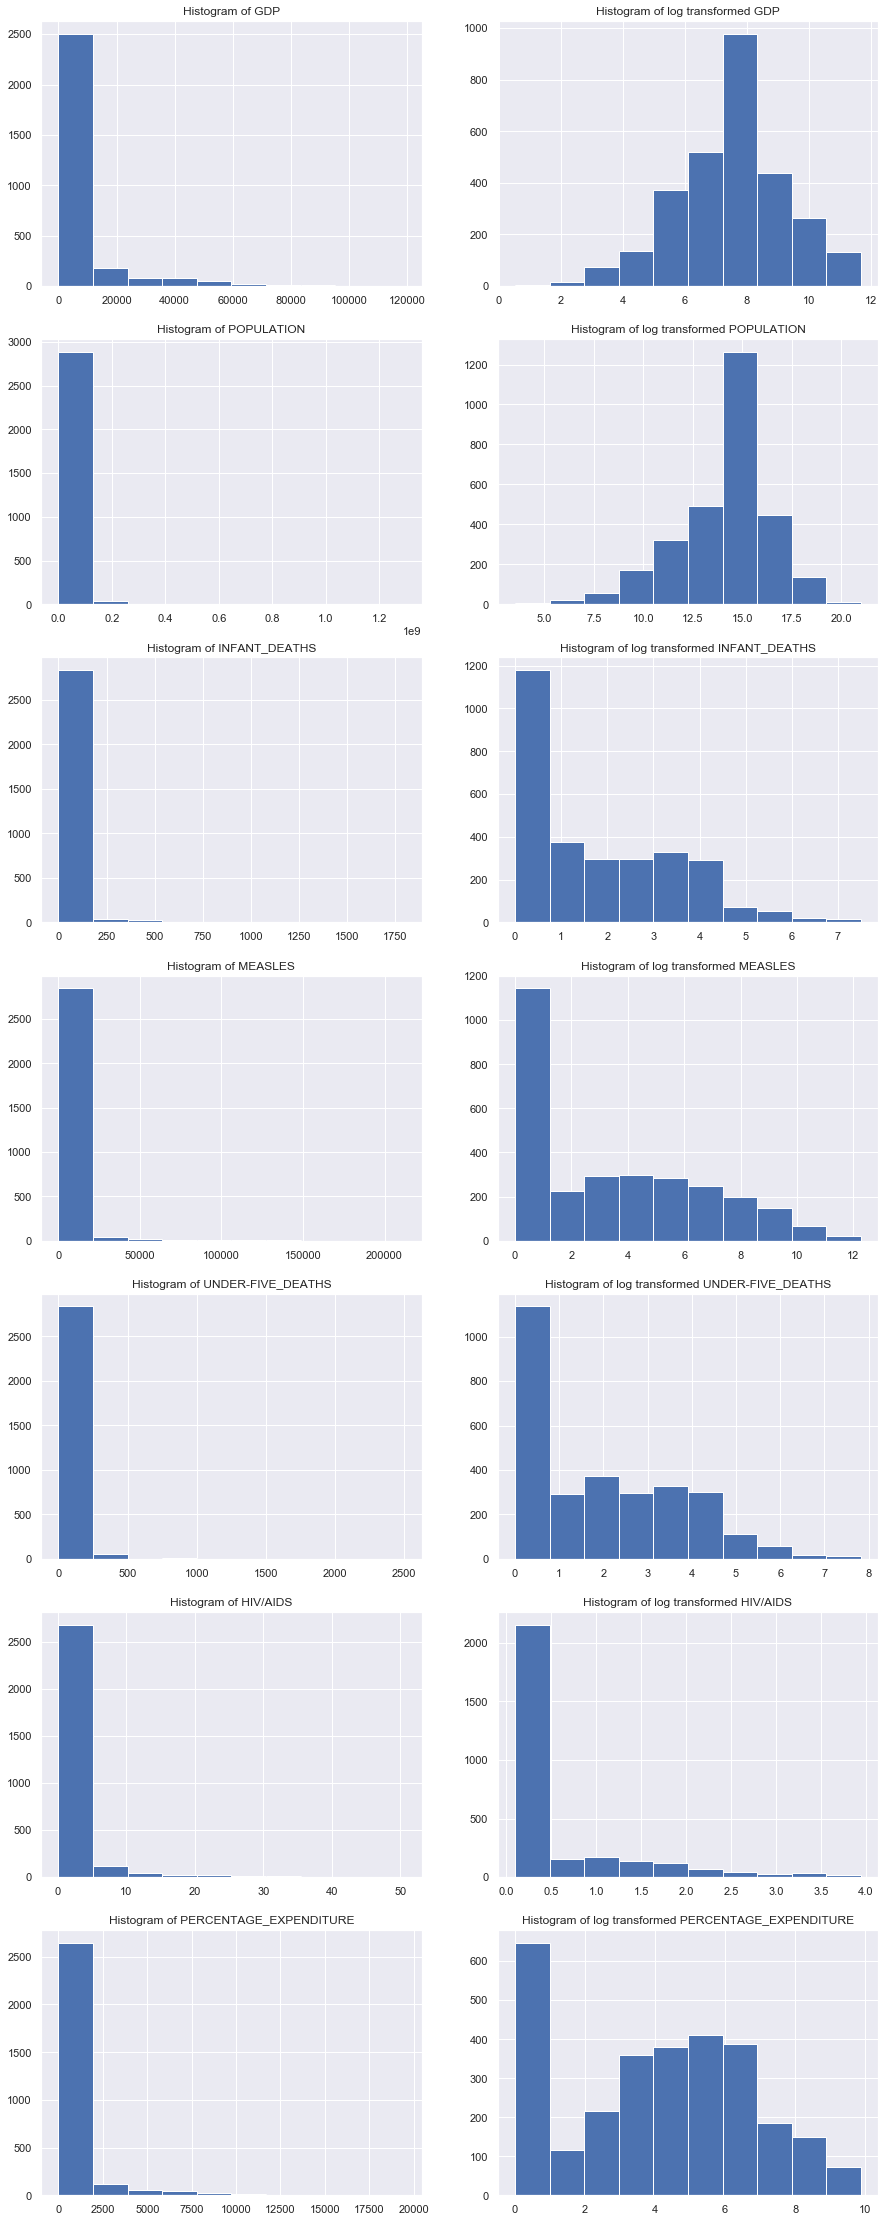

In [132]:
# check histograms of log transformation for GDP and POPULATION

plt.figure(figsize = (15,40))

constant = 1

plt.subplot(7,2,1)
plt.hist(lifex_df2["gdp"])
plt.title("Histogram of GDP")

plt.subplot(7,2,2)
plt.hist(np.log(lifex_df2["gdp"]))
plt.title("Histogram of log transformed GDP")

plt.subplot(7,2,3)
plt.hist(lifex_df2["population"])
plt.title("Histogram of POPULATION")

plt.subplot(7,2,4)
plt.hist(np.log(lifex_df2["population"]))
plt.title("Histogram of log transformed POPULATION")

plt.subplot(7,2,5)
plt.hist(lifex_df2["infant_deaths"])
plt.title("Histogram of INFANT_DEATHS")

plt.subplot(7,2,6)
plt.hist(np.log(lifex_df2["infant_deaths"] + constant))
plt.title("Histogram of log transformed INFANT_DEATHS")

plt.subplot(7,2,7)
plt.hist(lifex_df2["measles"])
plt.title("Histogram of MEASLES")

plt.subplot(7,2,8)
plt.hist(np.log(lifex_df2["measles"] + constant))
plt.title("Histogram of log transformed MEASLES")

plt.subplot(7,2,9)
plt.hist(lifex_df2["under-five_deaths"])
plt.title("Histogram of UNDER-FIVE_DEATHS")

plt.subplot(7,2,10)
plt.hist(np.log(lifex_df2["under-five_deaths"] + constant))
plt.title("Histogram of log transformed UNDER-FIVE_DEATHS")

plt.subplot(7,2,11)
plt.hist(lifex_df2["hiv/aids"])
plt.title("Histogram of HIV/AIDS")

plt.subplot(7,2,12)
plt.hist(np.log(lifex_df2["hiv/aids"] + constant))
plt.title("Histogram of log transformed HIV/AIDS")

plt.subplot(7,2,13)
plt.hist(lifex_df2["percentage_expenditure"])
plt.title("Histogram of PERCENTAGE_EXPENDITURE")

plt.subplot(7,2,14)
plt.hist(np.log(lifex_df2["percentage_expenditure"] + constant))
plt.title("Histogram of log transformed PERCENTAGE_EXPENDITURE")

plt.show()

Although some of the histograms above still skew left strongly, they all take a step towards normality (and away from extreme outliers) after the log transformation.

In [133]:
#commit to the log transformation for these 7 variables

lifex_df2["gdp"] = (np.log(lifex_df2["gdp"]))
lifex_df2["population"] = (np.log(lifex_df2["population"]))
lifex_df2["infant_deaths"] = (np.log(lifex_df2["infant_deaths"] + constant))
lifex_df2["measles"] = (np.log(lifex_df2["measles"] + constant))
lifex_df2["under-five_deaths"] = (np.log(lifex_df2["under-five_deaths"] + constant))
lifex_df2["hiv/aids"] = (np.log(lifex_df2["hiv/aids"] + constant))
lifex_df2["percentage_expenditure"] = (np.log(lifex_df2["percentage_expenditure"] + constant))

In [140]:
#clean up a few more outliers with winsorization

lifex_df2["hepatitis_b"] = winsorize(lifex_df2["hepatitis_b"], (0.1, 0))
lifex_df2["population"] = winsorize(lifex_df2["population"], (0.05, 0))
lifex_df2["adult_mortality"] = winsorize(lifex_df2["adult_mortality"], (0, 0.05))
lifex_df2["polio"] = winsorize(lifex_df2["polio"], (0.1, 0))
lifex_df2["total_expenditure"] = winsorize(lifex_df2["total_expenditure"], (0, 0.05))
lifex_df2["diphtheria"] = winsorize(lifex_df2["diphtheria"], (0.1, 0))
lifex_df2["thinness__1-19_years"] = winsorize(lifex_df2["thinness__1-19_years"], (0, 0.05))
lifex_df2["thinness_5-9_years"] = winsorize(lifex_df2["thinness_5-9_years"], (0, 0.05))
lifex_df2["hiv/aids"] = winsorize(lifex_df2["hiv/aids"], (0, 0.1))

In [141]:
lifex_df2_numeric = lifex_df2.drop(['country', 'status'], axis=1)

Let's check our boxplots again to see the effect of winsorization.

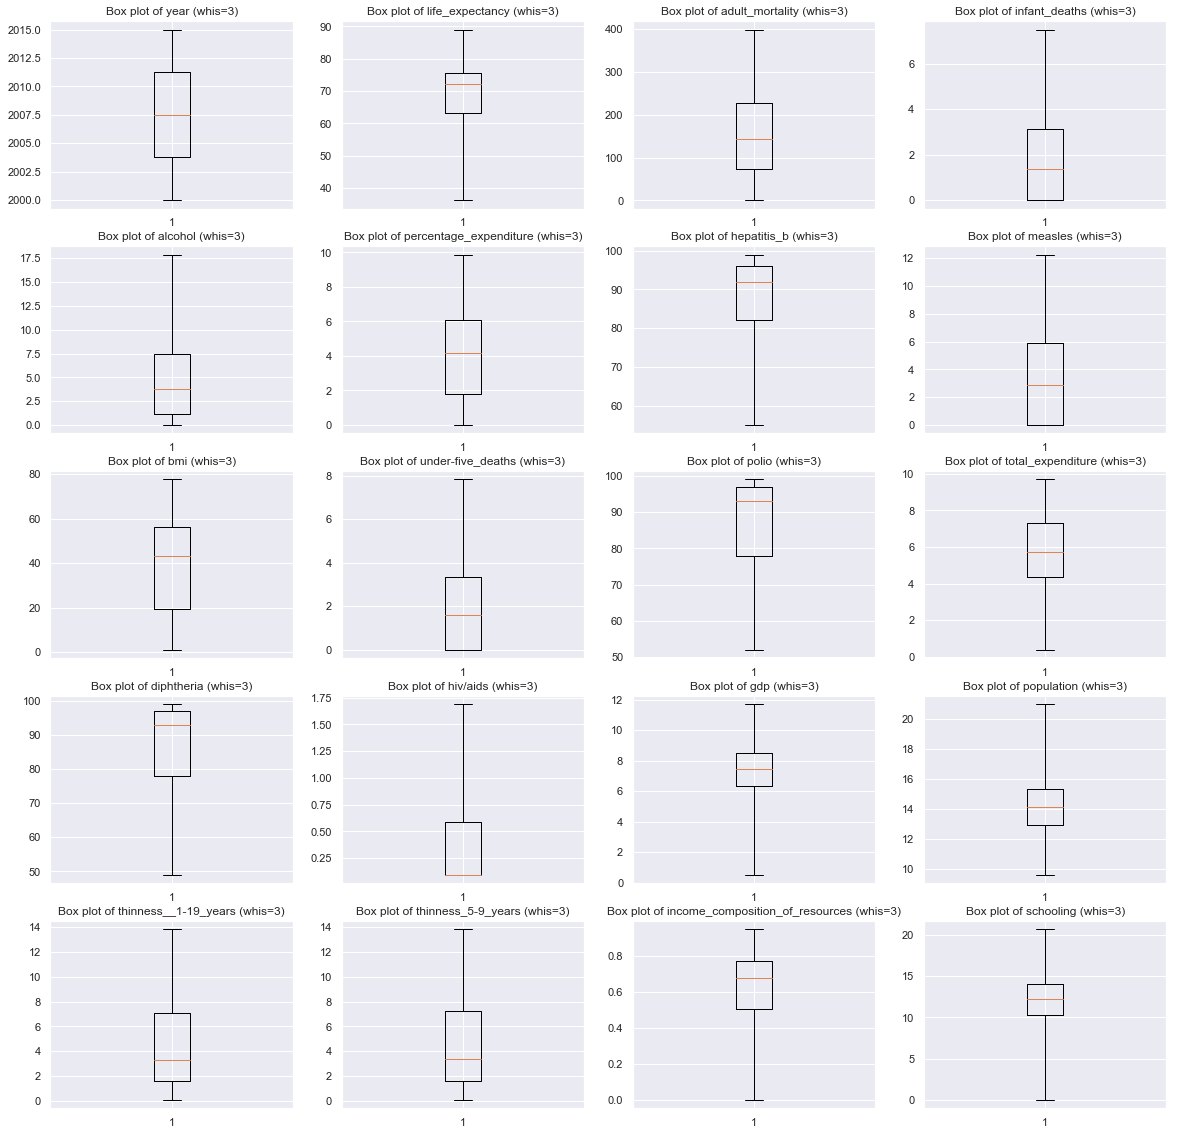

In [142]:
## check again for outliers in boxplots

plt.figure(figsize = (20,20))

i = 1

for col in lifex_df2_numeric.columns:
    plt.subplot(5,4,i)
    plt.boxplot(lifex_df2[col], whis=3)
    plt.title("Box plot of {} (whis=3)".format(col))
    i+=1
    
plt.show()

- The outliers have been removed!
- Let's check out all of the histograms of our processed variables

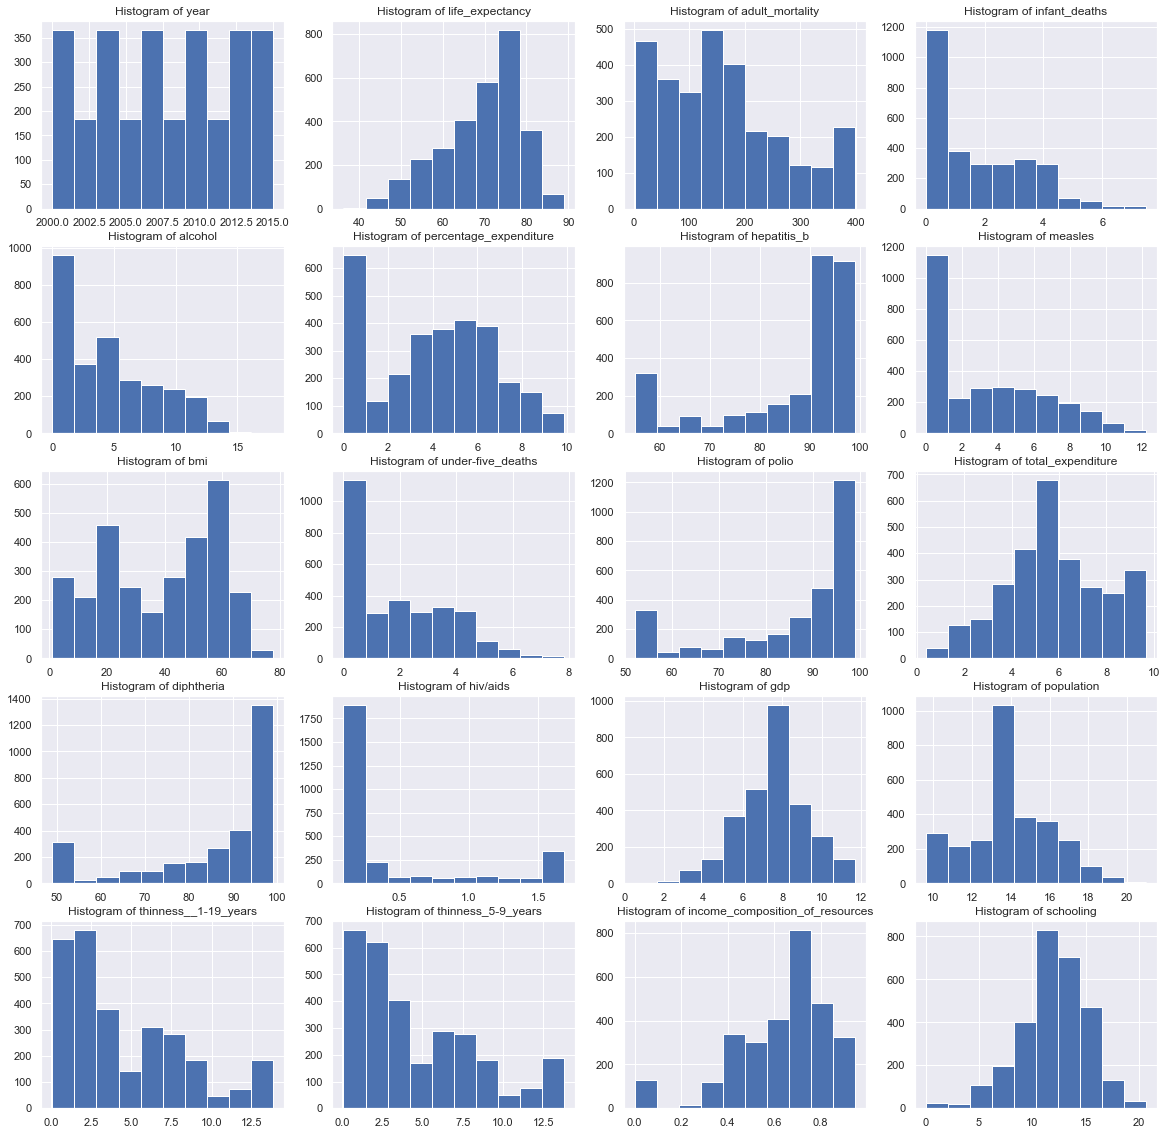

In [144]:
plt.figure(figsize = (20,20))

i = 1

for col in lifex_df2_numeric.columns:
    plt.subplot(5,4,i)
    plt.hist(lifex_df2_numeric[col])
    plt.title("Histogram of {}".format(col))
    i+=1
    
plt.show()

- Only a handful of the variables approach normality.  This could be more or less relevant depending on the models that we want to use (e.g. Naive Bayes).  It is beyond the scope of this report, but we could try applying some more transformations (like BoxCox) to the variables to improve their model-friendliness.
- Visual inspection of the histograms suggests that some of the variables may be highly correlated, e.g. the two 'thinness' variables
- Let's take a closer look at correlation in our feature engineering section below.

## Feature Engineering

We have one categorical variable which might be useful as a feature: 'status'.

In [146]:
lifex_df2['status'].value_counts()

Developing    2416
Developed      512
Name: status, dtype: int64

In [147]:
#get a dummy variable for status

lifex_df2_numeric = pd.concat([lifex_df2_numeric,
                               pd.get_dummies(lifex_df2[['status']], drop_first=True)], axis=1)

Now that we've processed and cleaned our data, let's check the summary stats again.  We'll try to start selecting which variables we want to use as features for modeling.

In [153]:
lifex_df2_numeric.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,...,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling,status_Developing
count,2928.00000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,...,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,2007.50000,69.224932,159.699795,1.774625,4.559167,3.992276,86.373975,3.368518,38.291291,1.946710,...,5.819467,85.244877,0.437083,7.468989,14.031605,4.634699,4.642520,0.630128,12.016052,0.825137
std,4.61056,9.523867,110.270130,1.662637,3.920534,2.728584,13.699238,3.258686,19.857308,1.781213,...,2.143782,15.905506,0.560038,1.730934,2.141759,3.769720,3.781344,0.205440,3.254407,0.379915
min,2000.00000,36.300000,1.000000,0.000000,0.010000,0.000000,55.000000,0.000000,1.000000,0.000000,...,0.370000,49.000000,0.095310,0.519597,9.610994,0.100000,0.100000,0.000000,0.000000,0.000000
25%,2003.75000,63.100000,74.000000,0.000000,1.107500,1.767095,82.000000,0.000000,19.400000,0.000000,...,4.370000,78.000000,0.095310,6.360950,12.943522,1.600000,1.600000,0.504000,10.300000,1.000000
50%,2007.50000,72.100000,144.000000,1.386294,3.770000,4.198876,92.000000,2.890372,43.350000,1.609438,...,5.750000,93.000000,0.095310,7.475891,14.146077,3.300000,3.400000,0.677000,12.300000,1.000000
75%,2011.25000,75.700000,228.000000,3.135494,7.400000,6.094955,96.000000,5.895091,56.100000,3.367296,...,7.330000,97.000000,0.587787,8.475043,15.339995,7.100000,7.200000,0.773000,14.100000,1.000000
max,2015.00000,89.000000,399.000000,7.496097,17.870000,9.877190,99.000000,12.265209,77.600000,7.824446,...,9.690000,99.000000,1.686399,11.688329,20.980895,13.800000,13.800000,0.948000,20.700000,1.000000


In [155]:
#'polio' is hidden in the above table
lifex_df2_numeric.polio.describe()

count    2928.000000
mean       85.589481
std        15.275027
min        52.000000
25%        78.000000
50%        93.000000
75%        97.000000
max        99.000000
Name: polio, dtype: float64

- Although variance is the square of the standard deviation which is included in the summary statistics, it is a useful statistic, and some prefer it to be listed explicitly.  Our largest standard deviation prize goes to the 'adult_mortality' variable; it also has the largest variance by far.  It is worth mentioning that these variables have different scales.  If we wanted to compare standard deviations or variances among variables, we could first normalize the data.   

In [158]:
for col in lifex_df2_numeric.columns:
    print('Variance of {}: '.format(col))
    print(np.var(lifex_df2_numeric[col]), '\n')

Variance of year: 
21.25 

Variance of life_expectancy: 
90.67307376582568 

Variance of adult_mortality: 
12155.348743127435 

Variance of infant_deaths: 
2.7634166270142986 

Variance of alcohol: 
15.365337556921723 

Variance of percentage_expenditure: 
7.442627006058155 

Variance of hepatitis_b: 
187.60501944201332 

Variance of measles: 
10.615405269917979 

Variance of bmi: 
394.1780081694279 

Variance of under-five_deaths: 
3.171635443441961 

Variance of polio: 
233.24677459389554 

Variance of total_expenditure: 
4.594231819963253 

Variance of diphtheria: 
252.89871009416825 

Variance of hiv/aids: 
0.313535123604041 

Variance of gdp: 
2.99510784242051 

Variance of population: 
4.585563491655 

Variance of thinness__1-19_years: 
14.205933926065414 

Variance of thinness_5-9_years: 
14.293680395754942 

Variance of income_composition_of_resources: 
0.0421911970533933 

Variance of schooling: 
10.587549713151978 

Variance of status_Developing: 
0.1442861835229478 



With our descriptive statistics in mind, we now check the correlation of our variables with the target.

In [151]:
np.abs(lifex_df2_numeric[
    lifex_df2_numeric.select_dtypes([
        'int64', 'float64', 'uint8']).columns].iloc[:,1:].corr().loc[:,'life_expectancy']).sort_values(ascending=False)


life_expectancy                    1.000000
hiv/aids                           0.796184
schooling                          0.717314
income_composition_of_resources    0.688591
adult_mortality                    0.682044
under-five_deaths                  0.621412
infant_deaths                      0.592200
polio                              0.568568
diphtheria                         0.568529
bmi                                0.558888
gdp                                0.558220
thinness_5-9_years                 0.525866
thinness__1-19_years               0.525167
status_Developing                  0.482136
alcohol                            0.390674
percentage_expenditure             0.374278
measles                            0.324932
hepatitis_b                        0.234644
total_expenditure                  0.219565
population                         0.090052
Name: life_expectancy, dtype: float64

This dataset has many variables with moderate to high correlation with the target, so let's drop everything less than a 0.5 correlation to start.

In [173]:
X = lifex_df2_numeric.drop(['status_Developing', 'alcohol', 'percentage_expenditure',
                            'measles', 'hepatitis_b', 'total_expenditure', 'population', 'year'], axis=1)

- Some of the variables we dropped seem intuitively unrelated to national life expectancy, e.g. population.
- Let's check the correlations among the remaining variables with a heatmap visualization.

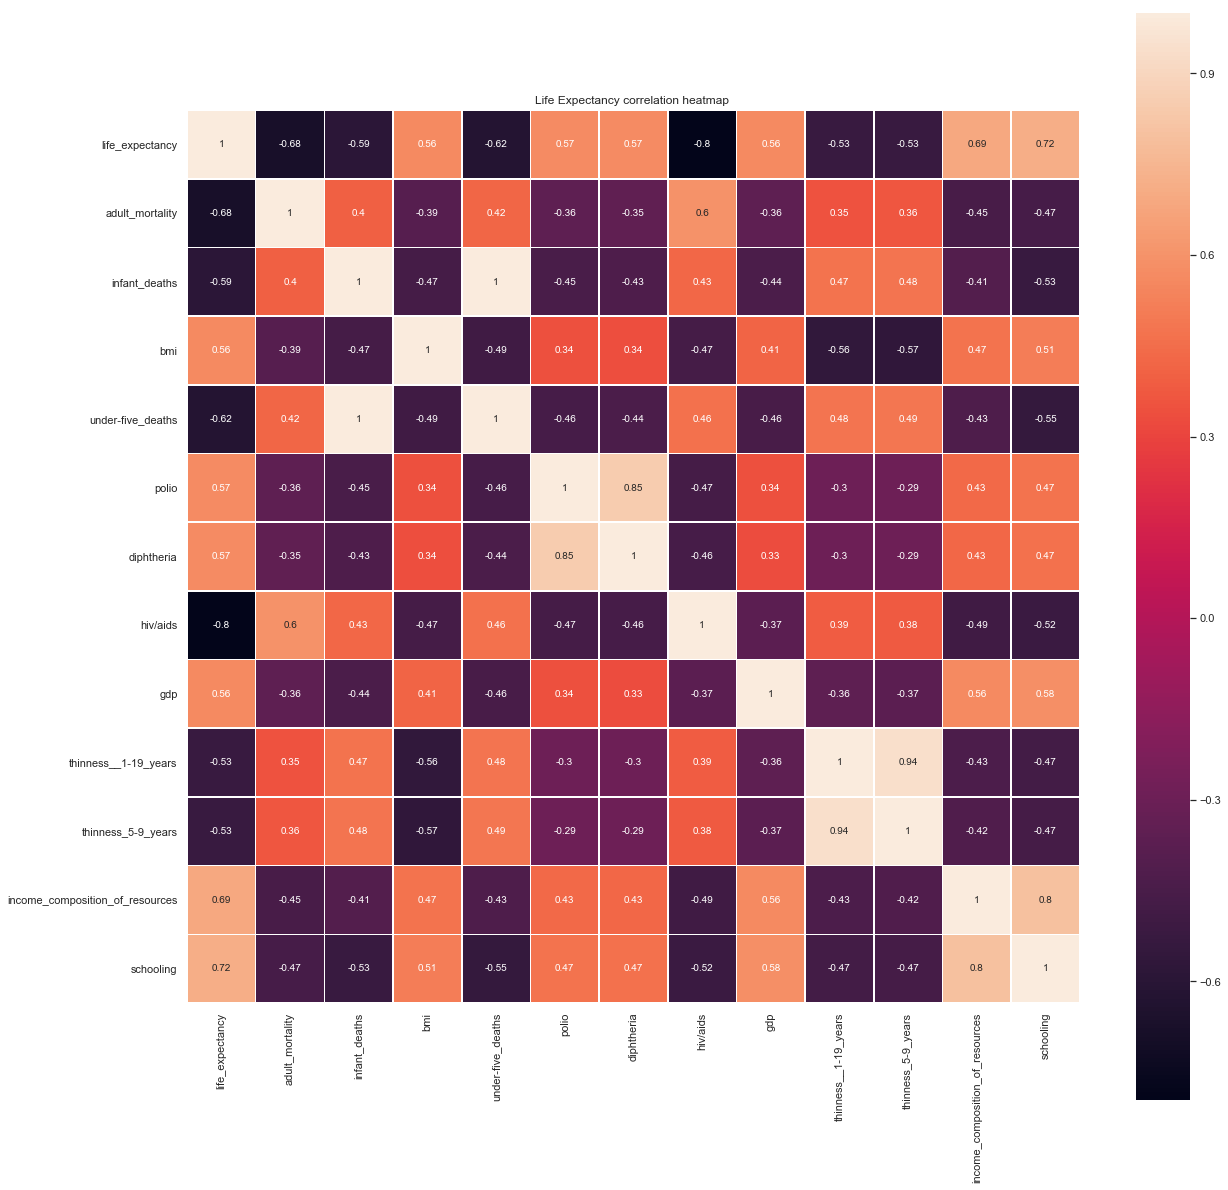

In [165]:
#check for correlation among variables

plt.figure(figsize=(20,20))

sns.heatmap(X.corr(), square=True, annot=True, linewidths=.5)
plt.title("Life Expectancy correlation heatmap ")

plt.show()

- As we suspected when viewing the histograms, some of the variables are highly correlated with each other.  The two 'thinness' variables with each other, and 'diptheria' with 'polio', and 'infant_deaths' with 'under-five_deaths' all stand out.
- At least one of each of those pairs should be dropped from the feature set (or the correlated variables could be combined into one).
- 'income_composition_of_resources' and 'schooling' are also highly correlated with each other, as well as with the target.  Let's check them out with a bivariate visualization.

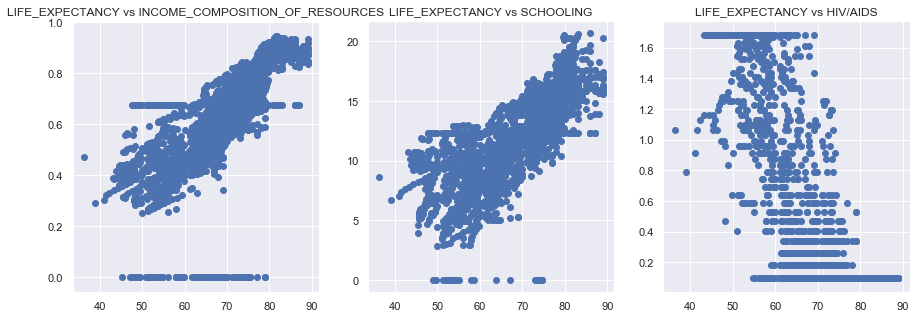

In [168]:
#generate scatter plots

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(lifex_df2_numeric["life_expectancy"], lifex_df2_numeric["income_composition_of_resources"])
plt.title("LIFE_EXPECTANCY vs INCOME_COMPOSITION_OF_RESOURCES")

plt.subplot(1,3,2)
plt.scatter(lifex_df2_numeric["life_expectancy"], lifex_df2_numeric["schooling"])
plt.title("LIFE_EXPECTANCY vs SCHOOLING")

plt.subplot(1,3,3)
plt.scatter(lifex_df2_numeric["life_expectancy"], lifex_df2_numeric["hiv/aids"])
plt.title("LIFE_EXPECTANCY vs HIV/AIDS")

plt.show()

- After seeing the scatter plots, we are more inclined to keep 'schooling' over 'income_composition_of_resources', but it may be OK to keep both in our feature set, especially if we are planning on using PCA. 
- We're not sure what to make of 'hiv/aids'.  This scatter plot looks odd, as does the histogram above, and the negative correlation with the target is high enough to be worrisome.

In [174]:
#Dropping some features that are highly correlated with other features, as well as 'hiv/aids', as well as the target variable

X = X.drop(['thinness__1-19_years', 'infant_deaths', 'diphtheria',
                            'income_composition_of_resources', 'hiv/aids'], axis=1)

## Summary

We worked our through a raw dataset and turned it into a feature set, ready to be implemented (and perhaps revised after testing) by some models.  We got to know the data through summary statistics and visualizations; we cleaned the data with imputation, winsorization, and log transformations, and we chose the best features for modeling through careful unvariate and bivariate analysis.  Along the way, we also made suggestions for expanding the work or potentially trying different strategies after running some models.  Here is our target variable and final feature set viewed as histograms:

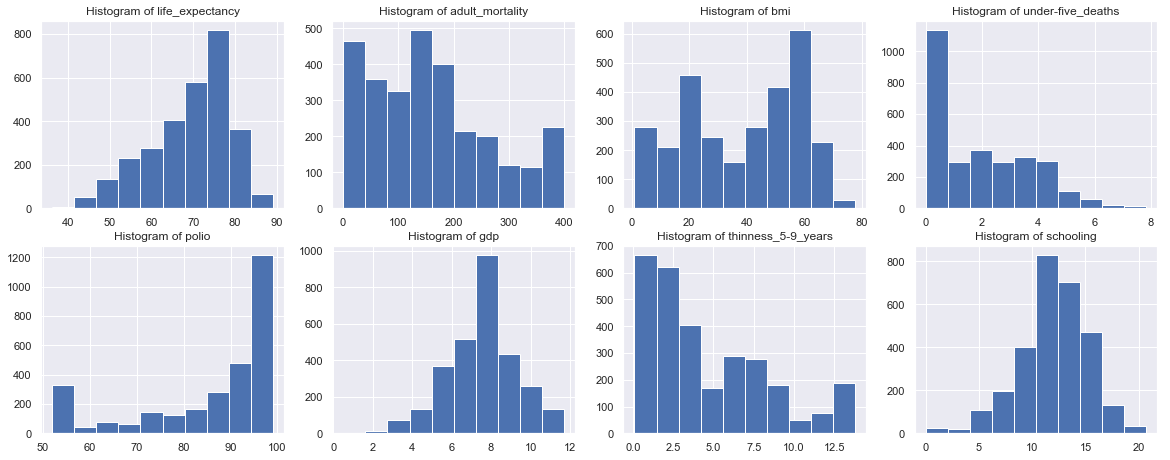

In [177]:
plt.figure(figsize = (20,20))

i = 1

for col in X.columns:
    plt.subplot(5,4,i)
    plt.hist(X[col])
    plt.title("Histogram of {}".format(col))
    i+=1
    
plt.show()

Fin.